# How to predict whether a wine is good ?

Based on a dataset of 4898 wines containing their quality (target) and 11 characteristics (features). The goal of this notebook is to see how to predict whether a wine is good or not, knowing its features, using random forest. The first section give hit of the features. The second section build a random forest model (using multi-core option integrated in scikit-learn) and try to assess the its precision and biais. Finally a graphical representation of the regression is given.

Test de modification

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Basic tools
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier,RandomForestRegressor

# Plot settings
mpl.rcParams['legend.frameon' ] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize' ] = 18
mpl.rcParams['axes.labelsize' ] = 18
mpl.rcParams['lines.linewidth'] = 2.5

## Preparation and inspection of the dataset

First, we load the dataset using pandas. Second, we rename each column with shorter name (more convenient for plotting) and then we simply suppress the first raw which contains the original names.

In [2]:
featureName = ['FA','VA','CA','RS','Ch','FS','TS','De','pH','Su','Al','Q']
mydata = pd.read_csv('WhiteWineQuality.csv', sep=";", names=featureName)

print('\nSize of the dataset: {}'.format(len(mydata)))
print( '--------------------')

print('\nOriginal Names')
print( '---------------')
print(mydata.head(1))

mydata = mydata[1:]
mydata = mydata.astype(float)
print( '\nAfter removing the long names' )
print( '-----------------------------')
mydata.head()



Size of the dataset: 4899
--------------------

Original Names
---------------
              FA                VA           CA              RS         Ch  \
0  fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   

                    FS                    TS       De  pH         Su       Al  \
0  free sulfur dioxide  total sulfur dioxide  density  pH  sulphates  alcohol   

         Q  
0  quality  

After removing the long names
-----------------------------


,FA,VA,CA,RS,Ch,FS,TS,De,pH,Su,Al,Q
1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
2,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
3,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
5,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


Then, we can check the scatter matrix very easily using the build-in function of pandas:

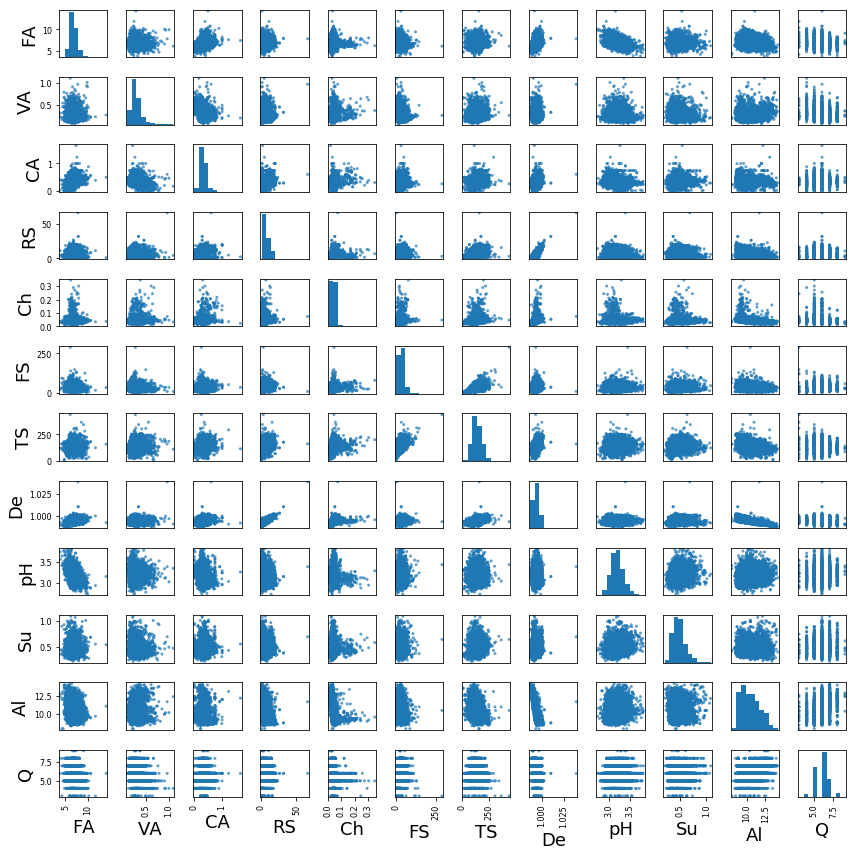

In [3]:
pd.plotting.scatter_matrix(mydata, figsize=(12,12), alpha=0.7, diagonal='hist')
plt.tight_layout()
plt.draw()

## Random forest regression

### Training

In order to get an machine learning algorithm working, one needs to define the target Y and the feature space X, as well as training and testing sample. This is what's done below: 

In [4]:
# Features and target
dataX = mydata.drop('Q',axis=1)
dataY = mydata['Q']

# Preparing cross validation samples
trainX, testX, trainY, testY = train_test_split(dataX, dataY, random_state=42, train_size=0.5)

Now any algorithm can be trained using these datasets. Below, we use a random forest with 1000 trees:

In [5]:
rf_regre = RandomForestRegressor(n_estimators=1000,n_jobs=-1).fit(trainX, trainY)

### Performance evaluation
Once the algorithm is trained, we can study his properties. In particular the performances can be assessed as the number of trees grows. In order to probe the predictive power of the algorithm, we define the biais and the precision as the average of and the variance of $F(\boldsymbol{X})-Y$ distribution over the training sample, respectively.

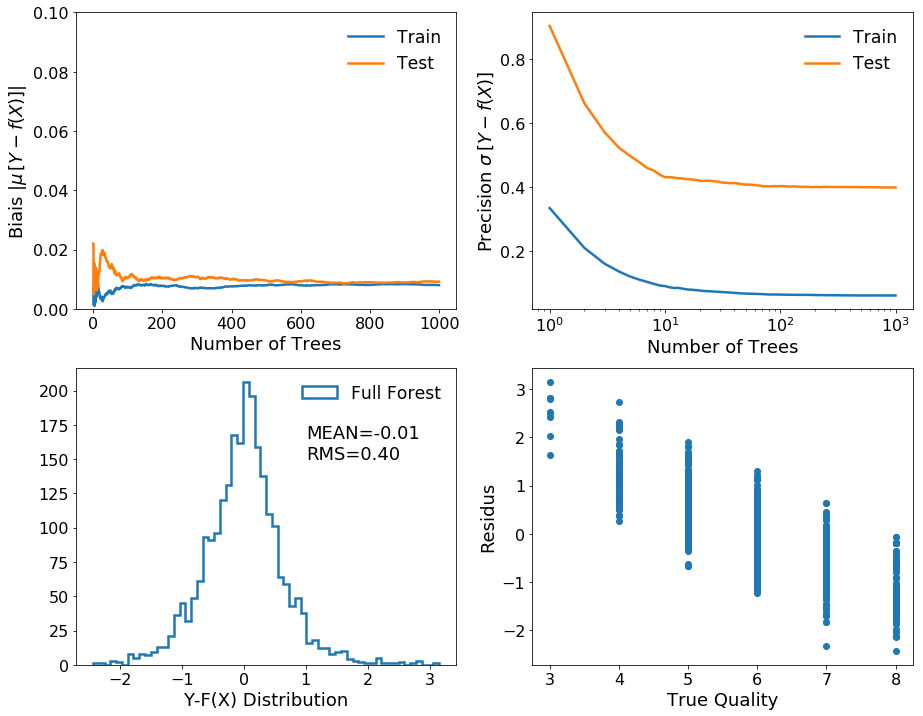

In [6]:
plt.figure(figsize=(15,12))

# 1. Check how the algorithm behaves with the number of trees
for sX, sY, label in [(trainX, trainY, 'Train'), (testX, testY, 'Test')]:
    predictions = np.zeros(len(sX))
    curve_rms   = []
    curve_mean  = []
    
    predictions = np.array( [tree.predict(sX) for tree in rf_regre.estimators_] )
    for i in range(0,rf_regre.n_estimators):
        if (i==0):
            Ypred=predictions[0]
        else:
            prediction_i = predictions[0:i]
            Ypred = np.average(prediction_i,axis=0)
            
        curve_rms .append( np.var(Ypred-sY) )
        curve_mean.append( np.abs(np.average(Ypred-sY)) )

    plt.subplot(221)
    plt.plot(curve_mean,label=label)
    plt.ylim(0.0,0.1)
    plt.xlabel('Number of Trees')
    plt.ylabel('Biais $|\mu\,[Y-f(X)]|$')
    plt.legend()
    
    plt.subplot(222)
    plt.plot(curve_rms,label=label)
    plt.ylabel('Precision $\sigma\,[Y-f(X)]$')
    plt.xlabel('Number of Trees')
    plt.semilogx()
    plt.legend()

# 2. Plot the distribution for the final prediction    
Ypred = rf_regre.predict(testX)
Ytrue = testY
plt.subplot(223)
plt.xlabel('Y-F(X) Distribution')
plt.hist( Ypred-Ytrue ,bins=60, histtype='step', linewidth=2.5, label='Full Forest')
plt.text(1, 150, 'MEAN={:0.2f}\nRMS={:.2f}'.format( np.average(Ypred-Ytrue), np.var(Ypred-Ytrue) ), fontsize=18)
plt.legend()

plt.subplot(224)
plt.xlabel('True Quality')
plt.ylabel('Residus')
plt.plot( Ytrue, Ypred-Ytrue, 'o')

The bottom right plot indicates that the residus (or biais) is more pronounced for the low quality wine $Q\lt6$. This algorithm slightly over estimate the low quality wine while it underestimate wine with $Q\gt6$.

### Plot the prediction of the model

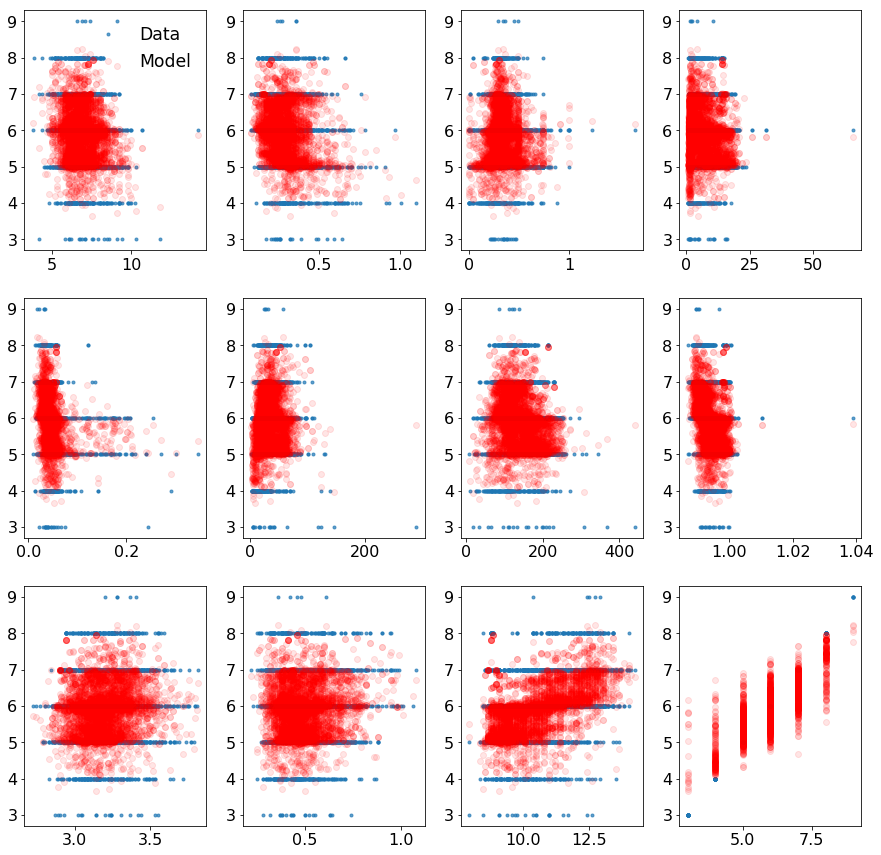

In [7]:
ymodel=rf_regre.predict(dataX)
y=mydata['Q']

i=0
plt.figure(figsize=(15,15))
for varname in mydata.columns:
    i=i+1
    x=mydata[varname]
    plt.subplot(3,4,i)
    plt.plot(x,y,'.',alpha=0.7, label='Data')
    plt.plot(x,ymodel,'ro',alpha=0.1,label='Model')  
    if (i==1):
        plt.legend()